In [2]:
"""Splitting a bunch of saved games into 2 parts:
1- Data for computing stats
2- Dataset to train model and predict in 10-fold CV
In fact, Stats is for previous data and that is why first we have to sort matches
and then choose an appropriate portion as stats and the rest for training and testing
"""

'Splitting a bunch of saved games into 2 parts:\n1- Data for computing stats\n2- Dataset to train model and predict in 10-fold CV\nIn fact, Stats is for previous data and that is why first we have to sort matches\nand then choose an appropriate portion as stats and the rest for training and testing\n'

# Imports

In [88]:
#Omid55
import requests
import pandas as pd
import pickle as pk
import csv
import time
import numpy as np
import random
from collections import defaultdict
import seaborn as sns
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix
import networkx as nx
% matplotlib inline

# Useful Classes and Functions

In [4]:
"""input: match (full match and not just id)
    output: list of summoner Ids, their selected champions and
    if they won or not (and in fact, in which team they were too)"""
def get_summonerIds_championIds_isWinner(match):
        parts = [ [pa['participantId'], pa['player']['summonerId']] 
                    for pa in match['participantIdentities'] ]
        return [ [part[1], pa['championId'], pa['stats']['winner']]
                              for part in parts for pa in match['participants'] 
                                  if pa['participantId'] == part[0] ]

In [5]:
"""ChampionResult is a simple class with number of
    wins and loses as integer value"""
class ChampionResult:
    def __init__(self):
        self.wins = 0
        self.loses = 0
    
    def get_win_ratio(self):
        #assert self.wins + self.loses != 0, 'There is no matches available...'
        if not self.wins + self.loses:
            return 0
        return self.wins / float(self.wins + self.loses)
    
    def get_game_count(self):
        return self.wins + self.loses
        
        
"""SummonerChampionStats has a hashtable of champions which
    describes how many time summoner won or lost with that
    (GameResult as each item)"""
class SummonerChampionStats:
    def __init__(self):
        self.champions = defaultdict(lambda: ChampionResult())
    
    def get_game_count(self):
        return sum([c.get_game_count() for c in self.champions.values()])
    
    def get_win_ratio(self):
        w = sum([c.wins for c in self.champions.values()])
        l = sum([c.loses for c in self.champions.values()])
        #assert w + l != 0, 'There is no matches available...'
        if not w + l:
            return 0
        return w / float(w+l)
        
    def get_same_champion_game_count(self, champId):
        return self.champions[champId].get_game_count()
        
    def get_same_champion_win_ratio(self, champId):
        return self.champions[champId].get_win_ratio()
        

In [6]:
# preprocessing summoners from matches in order to have a dictionary of summoners with
#    a dictionary of their previous selected champions and GameResult for
#       for each selected champion (wins and loses)
def preprocess_given_matches(previous_matchIds_for_stats):
    summoners_stats = defaultdict(lambda: SummonerChampionStats())
    for mid in previous_matchIds_for_stats:
        summoner_champ_winner = get_summonerIds_championIds_isWinner(matches[mid])
        for s in summoner_champ_winner:
            if s[2]:
                summoners_stats[s[0]].champions[s[1]].wins += 1
            else:
                summoners_stats[s[0]].champions[s[1]].loses += 1
    return summoners_stats

# Start runing the script

Loading the data, it might take long

In [7]:
# loading all saved matches
with open('FIRST_SAVED_MATCHES.pkl', 'rb') as f:
    matches = pk.load(f)

Removing those matches that had fewer than 10 participants

In [8]:
to_be_deleted_indices = []
for mid, match in matches.items():
    if 'participants' not in match or len(match['participants']) < 10:
        to_be_deleted_indices.append(mid)
for ind in to_be_deleted_indices:
    del matches[ind]

In [9]:
print 'Length of all matches is', len(matches)

Length of all matches is 43462


# Run after done loading and cleanning the data

Splitting the data into 2 sets

In [ ]:
# THINK ABOUT A BETTER WAY TO SPLIT THE DATA << CHECK HERE >>

In [44]:
# selecting a sample of matches
SAMPLE_IT = False
if SAMPLE_IT:
    SAMPLE_SIZE = 10000
    sampled_matches_ids = [matches.keys()[s] for s in sorted(random.sample(range(len(matches)), SAMPLE_SIZE))]
else:  # all the data
    sampled_matches_ids = matches.keys()

# sorting matches with respect to their match creation date
dates = np.zeros(len(sampled_matches_ids))
for i, mid in enumerate(sampled_matches_ids):
    dates[i] = matches[mid]['matchCreation']
sampled_matches_ids_sorted = [x for (y,x) in sorted(zip(dates, sampled_matches_ids))]
#all(dates[i]<=dates[i+1] for i in range(len(dates)-1))  # for checking if this is sorted or no

# spliting the data to 80% for stats and 20% for dataset (train and test for 10-fold CV)
stats_len = int(0.7*len(sampled_matches_ids_sorted))
matchIds_for_stats = sampled_matches_ids_sorted[:stats_len]
matchIds_for_dataset = sampled_matches_ids_sorted[stats_len:]
print 'Length of matchIds_for_stats is', len(matchIds_for_stats), '\nLength of matchIds_for_dataset is', len(matchIds_for_dataset)

Length of matchIds_for_stats is 30423 
Length of matchIds_for_dataset is 13039


# Building the network of games from stats data

get the index for a sid in the network, it adds a new node if sid does not exist

In [83]:
def get_the_index_for_sid(sid):
    if sid not in sid_map:
        sid_map[sid] = len(sid_map)
    return sid_map[sid]

# in general format
def get_index_for(dictionary, val):
    if val not in dictionary:
        dictionary[val] = len(dictionary)
    return dictionary[val]

In [53]:
# finding the number of unique summoners
all_sids_in_stats = []
for mid in matchIds_for_stats:
    sc = get_summonerIds_championIds_isWinner(matches[mid])
    all_sids_in_stats+=[s[0] for s in sc]
N = len(set(all_sids_in_stats))
del all_sids_in_stats
print 'There are', N, 'unique summoners in the stats data.'

There are 206453 unique summoners in the stats data.


In [54]:
sid_map = {}
edges = defaultdict(lambda: 0)
for mid in matchIds_for_stats:
    sc = get_summonerIds_championIds_isWinner(matches[mid])
    # WHEN WE USE NEW SAVED MATCHES, THEN THERE IS NO NEED TO APPLY FUNCTION get_summonerIds_championIds_isWinner << CHECK HERE >>
    for i in range(len(sc)):
        for j in range(i+1, len(sc)):
            if sc[i][2] == sc[j][2]:   # if they were in the same team
                key = str(get_the_index_for_sid(sc[i][0])) + ',' + str(get_the_index_for_sid(sc[j][0]))
                edges[key] += 1
row, col, val = [], [], []
for k, v in edges.items():
    coordination = k.split(',')
    row.append(int(coordination[0]))
    col.append(int(coordination[1]))
    val.append(v)
# since N is so large, we build a sparse matrix to save the entire network in it
W = csr_matrix((val, (row, col)), shape=(N,N), dtype=np.int8)
del edges, row, col, val

In [55]:
W

<206453x206453 sparse matrix of type '<type 'numpy.int8'>'
	with 576036 stored elements in Compressed Sparse Row format>

This part may take a long time to run

In [ ]:
# degree distribution of the network
plt.hist(sum(W).toarray())
plt.title('Degree distribution in the entire network');

# Building the dataset from the second part (dataset)

Preproccessing the stats part of data

In [78]:
summoners_stats = preprocess_given_matches(matchIds_for_stats)

In each match how many of summoners have been seen in the stats before

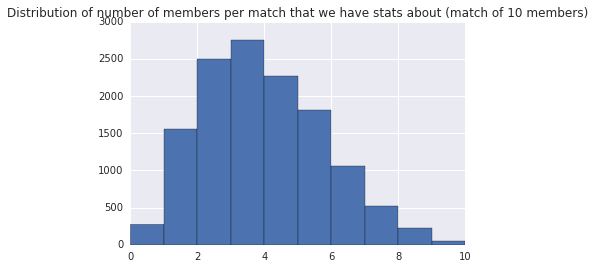

In [62]:
c = np.zeros(len(matchIds_for_dataset))
for i, mid in enumerate(matchIds_for_dataset):
    for s in get_summonerIds_championIds_isWinner(matches[mid]):
        if s[0] in summoners_stats:
            c[i] += 1
plt.hist(c)
plt.title('Distribution of number of members per match that we have stats about (match of 10 members)');

Building the dataset

In [87]:
# for each match in the dataset
data = []
MIN_COUNT_MEMBER = 4  # minimum number of team members that we have information about
for mid in matchIds_for_dataset:
    # ------------------------------------------------------------------
    # check if we have enough information about this match of not. In fact if
    #   we have fewer than MIN_COUNT_MEMBER number of people with info, we should
    #   get rid of that match
    w = 0
    l = 0
    for s in get_summonerIds_championIds_isWinner(matches[mid]):
        if s[0] in summoners_stats:
            if s[2]:
                w += 1
            else:
                l += 1
    if w < MIN_COUNT_MEMBER or l < MIN_COUNT_MEMBER:
        continue
    # ------------------------------------------------------------------
    
    summoners_not_found_winner = 0
    summoners_not_found_loser = 0
    winners = []
    losers = []
    winners_weight = []
    losers_weight = []
    
    sc = get_summonerIds_championIds_isWinner(matches[mid])
    
    # for team network 
    w_dict = {}
    l_dict = {}
    W_winner_team = np.zeros((5,5))
    W_loser_team = np.zeros((5,5))
    for i in range(len(sc)):
        for j in range(i+1, len(sc)):
            if sc[i][2] == sc[j][2]:
                if sc[i][0] in sid_map and sc[j][0] in sid_map:
                    if sc[i][2]:
                        ii = get_index_for(w_dict,i)
                        jj = get_index_for(w_dict,j)
                        W_winner_team[ii,jj] = W[get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0])]
                        W_winner_team[jj,ii] = W_winner_team[ii,jj]
                        winners_weight.append(W[get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0])])
                    else:
                        ii = get_index_for(l_dict,i)
                        jj = get_index_for(l_dict,j)
                        W_loser_team[ii,jj] = W[get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0])]
                        W_loser_team[jj,ii] = W_loser_team[ii,jj]
                        losers_weight.append(W[get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0])])
    # thus we have winner weights, loser weights
    #   and their adjacency matrix as W_winner_team, W_loser_team
    # ADD MORE SOPHISTICATED NETWORK FEATURES LIKE ALGEBRAIIC CONNECTIVITY AND SO FORTH << CHECK HERE >>
    wg = nx.Graph(W_winner_team)
    lg = nx.Graph(W_loser_team)
    # a list of features from network << CHECK HERE >>
    nx.algebraic_connectivity(wg)
    nx.algebraic_connectivity(lg)
    ...
    
    # for each member in each team
    for s in sc:
        stat = summoners_stats[s[0]]
        tmp = [
            stat.get_game_count(),
            stat.get_win_ratio(),
            stat.get_same_champion_game_count(s[1]),
            stat.get_same_champion_win_ratio(s[1])
        ]
        if s[2]:
            winners.append(tmp)
        else:
            losers.append(tmp)
    sample = list(np.average(winners, axis=0)) + \
        list(np.std(winners, axis=0)) + \
        [np.average(winners_weight),
        np.std(winners_weight)] + \
        list(np.average(losers, axis=0)) + \
        list(np.std(losers, axis=0)) + \
        [np.average(losers_weight),
        np.std(losers_weight)]
               
    data.append(sample)
    
    
print 'Data length is', len(data)

[[  0.   0.   0.   0.   0.]
 [  0.   0.  38.  33.  63.]
 [  0.  38.   0.   7.  39.]
 [  0.  33.   7.   0.  17.]
 [  0.  63.  39.  17.   0.]] [[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
Data length is 0


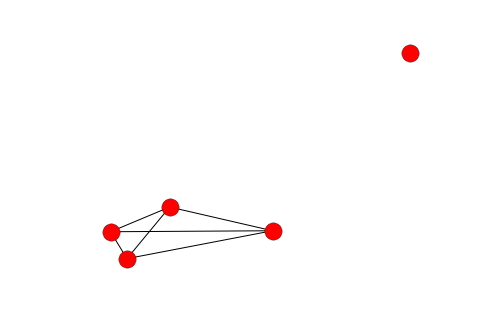

In [113]:
g = nx.Graph(data=W_winner_team)
nx.draw(g);

In [112]:
dataset = pd.DataFrame(data=data, columns=['winner_avg_game_count', 'winner_avg_win_ratio', 'winner_avg_same_champion_game_count', 'winner_avg_same_champion_win_ratio', 'winner_std_game_count', 'winner_std_win_ratio', 'winner_std_same_champion_game_count', 'winner_std_same_champion_win_ratio', 'winner_average_weight', 'winner_std_weight', 'loser_avg_game_count', 'loser_avg_win_ratio', 'loser_avg_same_champion_game_count', 'loser_avg_same_champion_win_ratio', 'loser_std_game_count', 'loser_std_win_ratio', 'loser_std_same_champion_game_count', 'loser_std_same_champion_win_ratio', 'loser_average_weight', 'loser_std_weight'])
dataset.to_csv('Classification2016_Dataset.csv')

In [75]:
dataset.shape

(178, 20)

In [76]:
dataset.head()

,winner_avg_game_count,winner_avg_win_ratio,winner_avg_same_champion_game_count,winner_avg_same_champion_win_ratio,winner_std_game_count,winner_std_win_ratio,winner_std_same_champion_game_count,winner_std_same_champion_win_ratio,winner_average_weight,winner_std_weight,loser_avg_game_count,loser_avg_win_ratio,loser_avg_same_champion_game_count,loser_avg_same_champion_win_ratio,loser_std_game_count,loser_std_win_ratio,loser_std_same_champion_game_count,loser_std_same_champion_win_ratio,loser_average_weight,loser_std_weight
0,94.0,0.411644,7.8,0.150000,80.744040,0.207710,14.147791,0.185592,19.7,21.166247,0.8,0.400000,0.0,0.000000,0.400000,0.489898,0.000000,0.000000,0.000000,0.000000
1,1.2,0.200000,0.0,0.000000,0.748331,0.244949,0.000000,0.000000,0.0,0.000000,56.6,0.485865,3.8,0.433333,52.890831,0.249323,3.919184,0.388730,14.100000,18.080100
2,0.8,0.400000,0.4,0.200000,0.400000,0.489898,0.489898,0.400000,0.0,0.000000,72.8,0.470860,14.8,0.258571,138.143983,0.337127,27.643444,0.323388,1.166667,2.608746
3,31.6,0.256579,15.2,0.265493,60.214948,0.321656,27.938504,0.329707,0.5,0.763763,0.8,0.600000,0.2,0.200000,0.400000,0.489898,0.400000,0.400000,0.000000,0.000000
4,41.2,0.277338,1.2,0.150000,63.725662,0.238878,1.469694,0.300000,1.5,4.500000,0.8,0.000000,0.2,0.000000,0.400000,0.000000,0.400000,0.000000,0.166667,0.372678
